# Mathematical Modeling Lab @ Constructor University 


$\text{A joint-work between Omar Elshinawy & Mohammad Habibi-Bennani, this project was completed in Spring of 2024 for a class in Mathematical }$
$\text{Modeling at Constructor University, under Professor Ivan Ovsyannikov and Mr Dzmitry Rumiantsau. }$

We start by importing the very basic libraries for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$\textbf{Problem 2.}$ We set $\zeta = 0.25,$  and proceed with $\dot x = v$

$$\ddot x + 0.5 \dot x + x = 0$$

which once again yields 

$$\frac d {dt} ~ y := \frac d {dt}~ \Big(\begin{matrix} x\\v\end{matrix}
\Big)= \begin{cases} \dot x = v \\ \dot v = -0.5 v - x\end{cases}$$

that is a first-order system of equations. We can represent this in python as follows,

In [2]:
def damped_oscillator_2(t, y):
    x, v = y
    return [v, -0.5*v - x]

given 

$$x(0) = 1, \quad x(9) = 0$$

In [3]:
x_0 = 1; x_9 = 0

and a timeframe

$$t \in [0, 9].$$

In [4]:
tframe = (0,9)

$\textbf{2.1 The Shooting Method.}$ 

This method is useful for boundary value problems like our problem here. The idea is to use a guess for the initial velocity $v_0,$ coupled with the given $x(0) = 1$ to attempt solving the system as an intermediate value problem. Here is the recipe:

$\textbf{1.}$ shoot for a guess $v(0);$  
$\textbf{2.}$ solve the IVP using $x(0), v(0);$  
$\textbf{3.}$ check the solution $\tilde x(9)$ versus $x(9);$

if $\tilde x(9)$ does not meet the boundary condition $x(9)$ then clearly it is incorrect so adjust the guess and re-iterate.

We define the shooting function for an initial guess $v_0,$ and solve it as an intermediate value problem. We use the solver `solve_ivp` specifically for that purpose.

In [5]:
from scipy.integrate import solve_ivp

Let us now rigorously formulate the previous ideas.

In [6]:
def shooting_function(v_0):
    sol = solve_ivp(damped_oscillator_2, tframe, [x_0, v_0], t_eval=np.linspace(0, 9, 1000))
    
    # 1. sol.y[0, t] gives x(t)
    # 2. sol.y[0, -1] gives x(9), as -1 returns the last value in the time array
    
    return sol.y[0, -1] - x_9

For the guess $v_0,$ our function returns the value of 

$$\tilde x(9) - x(9).$$

We want this to be zero. This is due to the fact that 

$$x(9) = x(9) \quad \text{ if and only if } \quad \tilde x(9) - x(9) = 0.$$

Let us worry less about solving this equation. For this purpose, we summon the ```root_scalar``` method to find us the right guess.

In [7]:
from scipy.optimize import root_scalar

# Find the guess v_0 which makes the equation 0.
sol = root_scalar(shooting_function, bracket=[-10, 10], method='brentq')
v_0 = sol.root

print(f"v_0 = {v_0}")

v_0 = 0.8741061753595658


We can now use the correct $v_0$ to solve the Intermediate Value Problem.

In [8]:
# Solve the IVP with the initial displacement + correct initial velocity
sol = solve_ivp(damped_oscillator_2, tframe, [x_0, v_0],  t_eval=np.linspace(0, 9, 1000))

# extract time values
t_shooting = sol.t

#extract x values 
x_shooting = sol.y[0]

#extract v values 
v_shooting = sol.y[1]

# Check out the shooting result!
#print(sol)

It now remains to "shoot our shot" with the results.

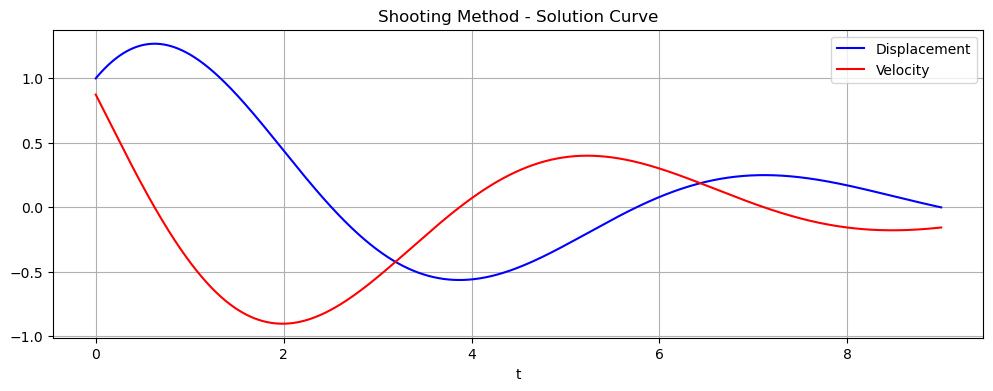

In [9]:
plt.figure(figsize=(12, 4,))

plt.plot(t_shooting, x_shooting, color='blue', label='Displacement')
plt.plot(t_shooting, v_shooting, color='red', label='Velocity')

plt.xlabel('t')
plt.title('Shooting Method - Solution Curve')
plt.legend()
plt.grid(True)
plt.show()

Bullseye. $\square$

$\textbf{2.2 The Finite Difference Method.}$ 

$\textbf{0)}$ For our differential equation

$$ \ddot{x} + 0.5 \dot{x} + x = 0 $$

with boundary conditions $ x(0) = 1 ~\text{and} ~ x(9) = 0,$ the goal is to summon the power of Linear Algebra to find values that approximate the function $x(t).$ 
* We discretize the time domain $[0, 9]$ into $n$ partitions $t_i.$   
* With $n$ such $t_i$ at hand, we have $n$ unknown variables $x_i := x(t_i)$ which we want to find the value for.   
* Therefore, it only makes sense to demand $n$ (linearly independent) equations in $n$ variables.   

We show that each equation is of the form

$$ 0 \cdot x_0 + \dots + 0 \cdot x_{i-2} + \big( \frac{1}{h^2} - \frac{0.25}h \big) \cdot x_{i-1} + \big(\frac{-2}{h^2} + 1\big) \cdot x_{i}  + \big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{i+1} + 0 \cdot x_{i+2} +  \dots + 0 \cdot x_n = 0$$

where $x_i$ are the displacement at time $t_i.$ The authors personally think this method is very creative in the way these equations are obtained. Not to cause confusion, we will use the following definitions interchangeabely.

$$\begin{align*}
t_{i\pm1} := t_i \pm h ~~~&\&~~~ x_{i} := x(t_{i})\\
\dot x_{i} := \dot x(t_{i}) \quad &\& \quad \ddot x_{i} := \ddot x(t_{i})
\end{align*}$$



$\textbf{I)}$ We start by discretizing the time domain. Divide the interval $[0, 9]$ into $N + 1$ subintervals to get $N$ interior points. The time step $h$ is therefore

$$ h = \frac{t_{N+1} - t_0}{N + 1} := \frac {9}{N+1}.$$

Thus, the total number of points, including the boundary points, will be $N + 2$. This is okay, however, as we already know the values of $x_0$ and $x_{N+1}$ as initial conditions. This is consistent with the $N$ unknown variables $x_{i}$ for $i \in \{1, \dots, N\},$ which are the interior points. We shall reference them using the same term in the code.

$\textbf{II)}$  We recall that the Taylor expansion of $x(t_i \pm h)$ is given by

$$x(t_{i+1}) := x(t_i + h) = x(t_i) + h \dot x(t_i) + \frac{h^2}{2} \ddot x(t_i) + \mathcal O(h^3) \quad (1)\\
x(t_{i-1}) := x(t_i - h) = x(t_i) - h \dot x(t_i) + \frac{h^2}{2} \ddot x(t_i) + \mathcal O(h^3) \quad (2)$$

$(1) + (2)$ is surprisingly not $3$, but it yields $(3)$ as we see below.

$$ \ddot{x}_i \approx \frac{x_{i+1} - 2x_i + x_{i-1}}{h^2} \quad (3)$$

More surprising is the fact that $(1) - (2)$ indeed gives $(-1)$, that is the last equation $(4)$ in our array of equations for this construction.

$$\dot x_i \approx \frac{x_{i+1} - x_{i-1}}{2h} \quad (4)$$

$\textbf{III)}$ Now, recall that the differential equation was given by $ \ddot{x} + 0.5 \dot{x} + x = 0 $ so we can use $(3), (4)$ to approximate the solution of $\ddot{x} + 0.5 \dot{x} + x = 0.$



$$\frac{x_{i+1} - 2x_i + x_{i-1}}{h^2} + 0.5 \cdot \frac{x_{i+1} - x_{i-1}}{2h} + x_i = 0.$$


With some simple algebra, we obtain that

$$\big( \frac{1}{h^2} - \frac{0.25}h \big) \cdot x_{i-1}  + \big(\frac{-2}{h^2} + 1\big) \cdot x_{i}  + \big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{i+1} = 0$$

which are all the coefficients we need. Notice that we can write

$$ 0 \cdot x_1 + \dots + 0 \cdot x_{i-2} + \big( \frac{1}{h^2} - \frac{0.25}h \big) \cdot x_{i-1} + \big(\frac{-2}{h^2} + 1\big) \cdot x_{i}  + \big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{i+1} + 0 \cdot x_{i+2} +  \dots + 0 \cdot x_n = 0$$

so that in each row only three coeffients are non-zero, namely $x_{i-1}, x_i, ~x_{i+1}.$ This makes the coefficient matrix $A$ tri-diagonal, which is crucial for how we construct $A \in \mathbb R^{N \times N}$ in our code.

$\textbf{IV)}$ Finally, notice that the variables $x_0, x_{N+1}$ are included in the first and last equations ```b[0]``` and ```b[-1]```. The catch is that our system is defined for $x_1, \dots, x_n.$ We need all equations to be of the form

$$a_1 x_1 + a_2 x_2 + \dots + a_n x_n = b_k$$
 
so the equations which include $x_0, x_{N+1}$ are dealt with in the manner shown below. 

$$\begin{align}
\big( \frac{1}{h^2} - \frac{0.25}{h} \big) \cdot x_{0} + \big(\frac{-2}{h^2} + 1\big) \cdot x_{1} +\big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{2} = 0 ~&\iff~  \big(\frac{-2}{h^2} + 1\big) \cdot x_{1} +\big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{2} = - \big( \frac{1}{h^2} - \frac{0.25}{h} \big) \cdot x_{0} \\
\big( \frac{1}{h^2} - \frac{0.25}{h} \big) \cdot x_{N-1} + \big(\frac{-2}{h^2} + 1\big) \cdot x_{N} +\big(\frac {1}{h^2} + \frac{0.25}{h}\big)\cdot x_{N+1} = 0  ~&\iff~ \big( \frac{1}{h^2} - \frac{0.25}{h} \big) \cdot x_{N-1} + \big(\frac{-2}{h^2} + 1\big) \cdot x_{N} = - \big(\frac {1}{h^2} +  \frac{0.25}{h}\big)\cdot x_{N+1}  \\
\end{align}$$


This is indeed successful, as we can make use of the boundary conditions $x_0,~x_{N+1}$ which are (respectively) $x(0) = 1, x(9) = 0$ in our problem here to compute `b[0]` and `b[-1] = b[N]` without any ambiguity.

In [10]:
def finite_difference(N, t_span, x_0, x_n1, zeta=0.25):
    
    # initialising 
    h = (t_span[1] - t_span[0]) / (N + 1)
    t = np.linspace(t_span[0], t_span[1], N + 2)
    # matrix A
    A = np.zeros((N, N)) 
    # n-dimensional solution vector
    b = np.zeros(N)
    
    # for each row (equation)
    for i in range(N):
        # avoids out of bounds error
        if i > 0: 
            A[i, i-1] = 1 / h**2 - 0.25 / h # insert coefficient of x_{i-1}
        A[i, i] = -2 / h**2 + 1 # insert coefficient of {x_i}
        # avoids out of bounds error
        if i < N - 1:
            A[i, i+1] = 1 / h**2 + 0.25 / h # insert coefficient of x_{i+1}
    
    # treating edge solutions
    b[0]  -= x_0 * (1/h**2 - 0.25/h)
    b[-1] -= x_n1 *(1/h**2 + 0.25/h)

    x_interior = np.linalg.solve(A, b)
    x = np.concatenate([[x_0], x_interior, [x_n1]])
    return t, x

We have successfully derived the finite differencing method, so we might as well put this nice construction into immediate use. We set the number of partitions, 

In [11]:
N = 100

then simply call the function with the correct parameters.

In [12]:
t_finite_diff, x_finite_diff = finite_difference(N, tframe, x_0, x_9)

To get more creative, we use the values `x_finite_diff` to find approximations to $v(t).$ This is made precise by means of equation $(4),$

$$\dot x_i \approx \frac{x_{i+1} - x_{i-1}}{2h} \quad (4)$$

as well as two more equations, namely the notorious

$$\dot x_i \approx \frac{x(t_i+h) - x(t_i)}{h} =: \frac{x_{i+1} - x_{i}}{h} \quad (5)$$

not to mention the less notorious but fairly obvious 

$$\dot x_i \approx \frac{x(t_i) - x(t_i - h)}{h} =: \frac{x_{i} - x_{i-1}}{h} \quad (6).$$

This is merely a change of variable so to say.

In [13]:
def compute_velocity(t_finite_diff, x_finite_diff):
    
    # Timestep is fixed
    h = t_finite_diff[1] - t_finite_diff[0]  
    
    # Give it structure like x_finite diff
    v_finite_diff = np.zeros_like(x_finite_diff) 

    # Equation (4) for interior points
    v_finite_diff[1:-1] = (x_finite_diff[2:] - x_finite_diff[:-2]) / (2 * h)

# Treating Edge Solutions #
    
    # Equation (5) for the first point
    v_finite_diff[0] = (x_finite_diff[1] - x_finite_diff[0]) / h

    # Equation (6) for the last point
    v_finite_diff[-1] = (x_finite_diff[-1] - x_finite_diff[-2]) / h

    return v_finite_diff

Now let us derive the array of values for $v,$

In [14]:
v_finite_diff = compute_velocity(t_finite_diff, x_finite_diff)

 Finally, a visually aesthetic curve of displacement and velocity versus time. 

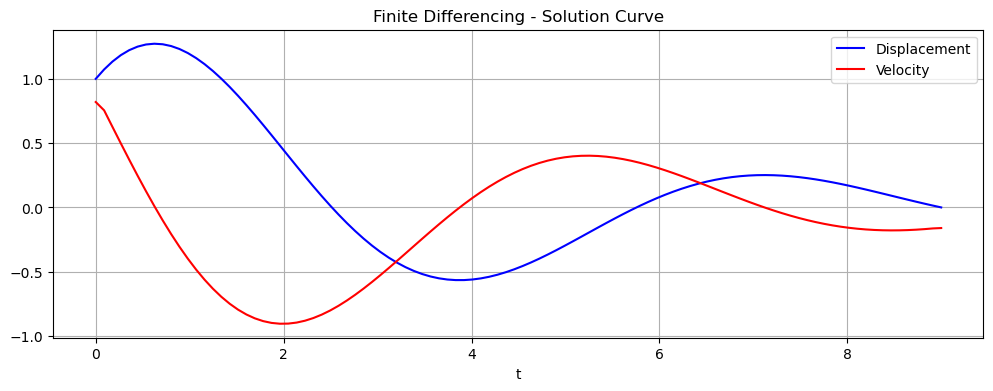

In [15]:
plt.figure(figsize=(12, 4,))

plt.plot(t_finite_diff, x_finite_diff, label='Displacement', color='blue')
plt.plot(t_finite_diff, v_finite_diff, label='Velocity', color='red')
plt.xlabel('t')
plt.title('Finite Differencing - Solution Curve')
plt.legend()
plt.grid(True)
plt.show()

Ladies and Gentlemen, Finite differencing! $\square$

$\textbf{2.3}$ ```scipy.integrate.solve_bvp```

This is fairly straightforward.

In [16]:
from scipy.integrate import solve_bvp

Start by discretize the interval $[0,9]$. Let us not forget to initialise the solution array `y = [x, t]` with trivial values as well.

In [17]:
t = np.linspace(0, 9, 100); y = np.zeros((2, t.size))

Recall the initial conditions $x(0) = 1 ~ \& ~ x(9) = 0$. We pass them down in the form

$$x(0) - 1 = 0 \quad \& \quad x(9) - 0 = 0.$$

Similar to the shooting function, the task is to minimise this residual of functions all the way to zero, so that the solution $\tilde x(0) = x(0).$

In [18]:
sol = solve_bvp(damped_oscillator_2, 
                lambda y_0, y_n: [y_0[0] - 1, y_n[0] - 0],
                t, y)
#print(sol)

Next, let us extract the data.

In [19]:
t_bvp = sol.x
x_bvp = sol.y[0]
v_bvp = sol.y[1]

We conclude this presentation with the following plot,

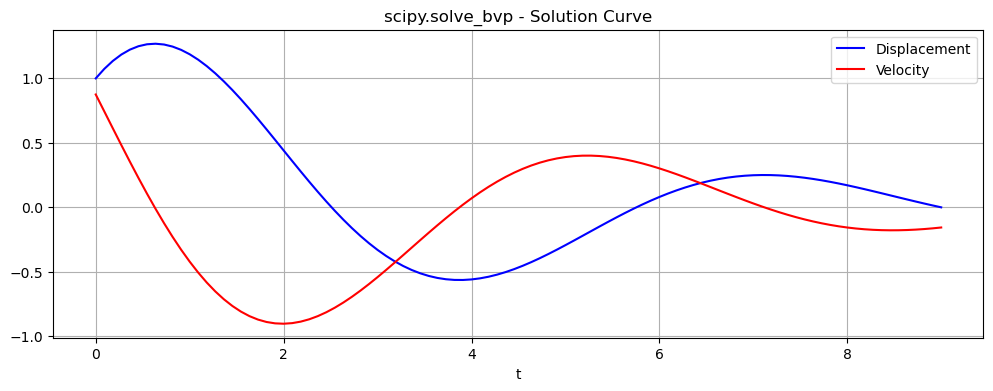

In [20]:
plt.figure(figsize=(12, 4,))
plt.plot(t_bvp, x_bvp, label='Displacement', color='blue')
plt.plot(t_bvp, v_bvp, label='Velocity', color='red')


plt.xlabel('t')
plt.title('scipy.solve_bvp - Solution Curve')
plt.legend()
plt.grid(True)
plt.show()

Sieht gut aus. $\square$